# Preparação do Dataset

In [1]:
pip install albumentations

  Obtaining dependency information for albumentations from https://files.pythonhosted.org/packages/8e/64/013409c451a44b61310fb757af4527f3de57fc98a00f40448de28b864290/albumentations-2.0.8-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 845.5 kB/s eta 0:00:00 0:00:01
  Obtaining dependency information for pydantic>=2.9.2 from https://files.pythonhosted.org/packages/82/2f/e68750da9b04856e2a7ec56fc6f034a5a79775e9b9a81882252789873798/pydantic-2.12.4-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.1 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for albucore==0.0.24 from https://files.pythonhosted.org/packages/0a/e2/91f145e1f32428e9e1f21f46a7022ffe63d11f549ee55c3b9265ff5207fc/albucore-0.0.24-py3-none-any.whl.metadata
  Obtaining dependency information for opencv-python-headless>=4.9.0.80 from https://files.pythonhosted.org/packages/89/53/e19c21e0c4eb1275c3e2c97b081103b6dfb3938172264d283a519bf728b9/opencv

In [2]:
import os
import glob
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A # Biblioteca pro para Augmentation
from albumentations.pytorch import ToTensorV2

# Mapeamento fixo das suas classes
CLASS_MAP = {
    'DATASET_CARURU': 1,
    'DATASET_GRAMINEA_PORTE_ALTO': 2,
    'DATASET_GRAMINEA_PORTE_BAIXO': 3,
    'DATASET_MAMONA': 4,
    'DATASET_OUTRAS_FOLHAS_LARGAS': 5,
    'DATASET_TREPADEIRA': 6
}

class DaninhasDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        
        # Considerando a estrutura do dataset daninhas_multiclasse: .../NOME_CLASSE/rgb/imagem.jpg e .../NOME_CLASSE/labels/mascara.png
        path_parts = img_path.split(os.sep)
        
        # Encontrar nome da classe no caminho
        class_id = 0
        for part in path_parts:
            if part in CLASS_MAP:
                class_id = CLASS_MAP[part]
                break
        
        # Caminho da máscara (ajuste a extensão se for .jpg ou .png)
        mask_path = img_path.replace('rgb', 'labels').replace('.jpg', '.png')
        
        image = np.array(Image.open(img_path).convert("RGB"))
        mask_rgb = np.array(Image.open(mask_path).convert("RGB"))
        
        # Converter máscara RGB para Máscara de Índices (0..6 e 255)
        mask_idx = np.full(mask_rgb.shape[:2], 255, dtype=np.uint8) # 255 = Ignorar (Branco)
        
        # Definir limites (ajuste fino se necessário)
        is_black = np.all(mask_rgb < [30, 30, 30], axis=-1)   # Fundo analisado
        is_white = np.all(mask_rgb > [240, 240, 240], axis=-1) # Fundo não analisado
        is_weed  = (~is_black) & (~is_white)                   # Daninha
        
        mask_idx[is_black] = 0        # Classe 0 (Fundo)
        mask_idx[is_weed] = class_id  # Classe 1-6 (Daninha)
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask_idx)
            image = augmented['image']
            mask_idx = augmented['mask']
            
        return image, mask_idx.long()

# Carregar arquivos
root_dir = "/media/guatambu/hdd/wesley/daninhas_multiclasse/"
all_files = sorted(glob.glob(os.path.join(root_dir, "*", "rgb", "*.jpg")))

train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)
val_files, test_files = train_test_split(val_files, test_size=0.5, random_state=42)

/home/guatambu/Documentos/kanashiro/dinov3-venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
len(train_files), len(val_files), len(test_files)

(8793, 1099, 1100)

In [151]:
def get_basic_transform():
    return A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

# Transformações com Augmentations
def get_aug_transform():
    return A.Compose([
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

In [5]:
pip install segmentation-models-pytorch torchmetrics

  Obtaining dependency information for segmentation-models-pytorch from https://files.pythonhosted.org/packages/ef/62/a50e5ac6191a498ad631e54df13d7e2d7eeb1325b15ee9ea1ee3ec065aaa/segmentation_models_pytorch-0.5.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 823.4 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Treinamento

In [153]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import JaccardIndex
from tqdm import tqdm 

# Configurações
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
LR = 0.0001
EPOCHS = 50 
IGNORE_INDEX = 255

criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)

Using device: cuda


In [145]:
def train_experiment(model, name, train_loader, val_loader, epochs):
    print(f"\nIniciando treinamento do modelo: {name}")
    
    model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    
    metric_iou = JaccardIndex(task="multiclass", num_classes=CLASSES, ignore_index=IGNORE_INDEX).to(DEVICE)
    
    history = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': []}
    best_iou = 0.0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        metric_iou.reset()
        
        loop = tqdm(train_loader, desc=f"Epoca {epoch+1}/{epochs} [{name}]", leave=False)
        
        for images, masks in loop:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            metric_iou.update(preds, masks)
            
            loop.set_postfix(loss=loss.item())
            
        avg_train_loss = train_loss / len(train_loader)
        avg_train_iou = metric_iou.compute().item()
        
        # validação
        model.eval()
        val_loss = 0.0
        metric_iou.reset()
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                preds = torch.argmax(outputs, dim=1)
                metric_iou.update(preds, masks)
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = metric_iou.compute().item()
        
        # Salvar histórico
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_iou'].append(avg_train_iou)
        history['val_iou'].append(avg_val_iou)
        
        print(f"Ep {epoch+1}: Train IoU: {avg_train_iou:.4f} | Val IoU: {avg_val_iou:.4f}")
        
        # Checkpoint (Salvar o melhor peso)
        if avg_val_iou > best_iou:
            best_iou = avg_val_iou
            torch.save(model.state_dict(), f"best_model_{name}.pth")
            
    print(f"Fim do treino de {name}. Melhor IoU: {best_iou:.4f}")
    return history

In [156]:
import segmentation_models_pytorch as smp

# Parâmetros
ENCODER = 'resnet18' # Encoder pré-treinado (ResNet18) [Se der tempo, treinar com outro depois]
CLASSES = 7 # 0 (fundo) + 6 plantas

# U-Net
model_unet = smp.Unet(encoder_name=ENCODER, encoder_weights='imagenet', classes=CLASSES)

# DeepLabV3+
model_deeplab = smp.DeepLabV3Plus(encoder_name=ENCODER, encoder_weights='imagenet', classes=CLASSES)

# FPN (Feature Pyramid Network)
model_fpn = smp.FPN(encoder_name=ENCODER, encoder_weights='imagenet', classes=CLASSES)

# Modelos com Augmentations
model_unet_com_aug = smp.Unet(encoder_name=ENCODER, encoder_weights='imagenet', classes=CLASSES)
model_deeplab_com_aug = smp.DeepLabV3Plus(encoder_name=ENCODER, encoder_weights='imagenet', classes=CLASSES)
model_fpn_com_aug = smp.FPN(encoder_name=ENCODER, encoder_weights='imagenet', classes=CLASSES)

In [155]:
# Criando os Datasets
train_dataset = DaninhasDataset(train_files, transform=get_basic_transform())
train_dataset_aug = DaninhasDataset(train_files, transform=get_aug_transform())
val_dataset   = DaninhasDataset(val_files, transform=get_basic_transform())
test_dataset  = DaninhasDataset(test_files, transform=get_basic_transform())

# Criando os Loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Dicionário com seus modelos instanciados
models_to_test = {
    "UNet": model_unet,
    "DeepLabV3+": model_deeplab,
    "FPN": model_fpn
}

# Dicionário com seus modelos instanciados com Augmentations
models_to_test_aug = {
    "UNet_com_Aug": model_unet_com_aug,
    "DeepLabV3+_com_Aug": model_deeplab_com_aug,
    "FPN_com_Aug": model_fpn_com_aug
}

results = {}

for model_name, model_instance in models_to_test.items():    
    hist = train_experiment(
        model=model_instance,
        name=model_name,
        train_loader=train_loader, 
        val_loader=val_loader,     
        epochs=EPOCHS
    )
    results[model_name] = hist

for model_name, model_instance in models_to_test_aug.items():    
    hist = train_experiment(
        model=model_instance,
        name=model_name,
        train_loader=train_loader_aug, 
        val_loader=val_loader,     
        epochs=EPOCHS
    )
    results[model_name] = hist


Iniciando treinamento do modelo: UNet


Epoca 1/50 [UNet]:   0%|          | 0/138 [00:00<?, ?it/s]

Ep 1: Train IoU: 0.1447 | Val IoU: 0.1926


Ep 2: Train IoU: 0.1902 | Val IoU: 0.1968


Ep 3: Train IoU: 0.2275 | Val IoU: 0.2112


Ep 4: Train IoU: 0.2485 | Val IoU: 0.2156


Ep 5: Train IoU: 0.2533 | Val IoU: 0.2356


Ep 6: Train IoU: 0.3003 | Val IoU: 0.2580


Ep 7: Train IoU: 0.3256 | Val IoU: 0.2447


Ep 8: Train IoU: 0.3459 | Val IoU: 0.2683


Ep 9: Train IoU: 0.3647 | Val IoU: 0.2344


Ep 10: Train IoU: 0.3826 | Val IoU: 0.3007


Ep 11: Train IoU: 0.3993 | Val IoU: 0.3314


Ep 12: Train IoU: 0.4035 | Val IoU: 0.2610


Ep 13: Train IoU: 0.4279 | Val IoU: 0.3264


Ep 14: Train IoU: 0.4872 | Val IoU: 0.3495


Ep 15: Train IoU: 0.5069 | Val IoU: 0.3862


Ep 16: Train IoU: 0.5164 | Val IoU: 0.3544


Ep 17: Train IoU: 0.5185 | Val IoU: 0.3891


Ep 18: Train IoU: 0.5292 | Val IoU: 0.4186


Ep 19: Train IoU: 0.5287 | Val IoU: 0.4021


Ep 20: Train IoU: 0.5344 | Val IoU: 0.3893


Ep 21: Train IoU: 0.5302 | Val IoU: 0.3862


Ep 22: Train IoU: 0.5309 | Val IoU: 0.3702


Ep 23: Train IoU: 0.5340 | Val IoU: 0.3352


Ep 24: Train IoU: 0.5321 | Val IoU: 0.3503


Ep 25: Train IoU: 0.5341 | Val IoU: 0.3815


Ep 26: Train IoU: 0.5316 | Val IoU: 0.3995


Ep 27: Train IoU: 0.5419 | Val IoU: 0.3743


Ep 28: Train IoU: 0.5454 | Val IoU: 0.4031


Ep 29: Train IoU: 0.5528 | Val IoU: 0.4090


Ep 30: Train IoU: 0.5554 | Val IoU: 0.3959


Ep 31: Train IoU: 0.5641 | Val IoU: 0.3917


Ep 32: Train IoU: 0.5604 | Val IoU: 0.3962


Ep 33: Train IoU: 0.5653 | Val IoU: 0.4026


Ep 34: Train IoU: 0.5591 | Val IoU: 0.4054


Ep 35: Train IoU: 0.5665 | Val IoU: 0.4019


Ep 36: Train IoU: 0.5658 | Val IoU: 0.3725


Ep 37: Train IoU: 0.5431 | Val IoU: 0.3021


Ep 38: Train IoU: 0.4960 | Val IoU: 0.2993


Ep 39: Train IoU: 0.4970 | Val IoU: 0.3846


Ep 40: Train IoU: 0.5482 | Val IoU: 0.4024


Ep 41: Train IoU: 0.5565 | Val IoU: 0.4138


Ep 42: Train IoU: 0.5631 | Val IoU: 0.4031


Ep 43: Train IoU: 0.5648 | Val IoU: 0.3850


Ep 44: Train IoU: 0.5683 | Val IoU: 0.4025


Ep 45: Train IoU: 0.5699 | Val IoU: 0.4009


Ep 46: Train IoU: 0.5798 | Val IoU: 0.4175


Ep 47: Train IoU: 0.5712 | Val IoU: 0.3981


Ep 48: Train IoU: 0.5730 | Val IoU: 0.4121


Ep 49: Train IoU: 0.5779 | Val IoU: 0.4095


Ep 50: Train IoU: 0.5749 | Val IoU: 0.4129
Fim do treino de UNet. Melhor IoU: 0.4186

Iniciando treinamento do modelo: DeepLabV3+


Ep 1: Train IoU: 0.1382 | Val IoU: 0.1986


Ep 2: Train IoU: 0.2484 | Val IoU: 0.2253


Ep 3: Train IoU: 0.2896 | Val IoU: 0.2709


Ep 4: Train IoU: 0.3207 | Val IoU: 0.3032


Ep 5: Train IoU: 0.3666 | Val IoU: 0.2970


Ep 6: Train IoU: 0.4165 | Val IoU: 0.3615


Ep 7: Train IoU: 0.4339 | Val IoU: 0.3511


Ep 8: Train IoU: 0.4661 | Val IoU: 0.3677


Ep 9: Train IoU: 0.4753 | Val IoU: 0.3461


Ep 10: Train IoU: 0.4876 | Val IoU: 0.3793


Ep 11: Train IoU: 0.5033 | Val IoU: 0.3838


Ep 12: Train IoU: 0.5095 | Val IoU: 0.3764


Ep 13: Train IoU: 0.5158 | Val IoU: 0.3329


Ep 14: Train IoU: 0.5209 | Val IoU: 0.3706


Ep 15: Train IoU: 0.5131 | Val IoU: 0.3823


Ep 16: Train IoU: 0.5177 | Val IoU: 0.3803


Ep 17: Train IoU: 0.5315 | Val IoU: 0.3829


Ep 18: Train IoU: 0.5384 | Val IoU: 0.3775


Ep 19: Train IoU: 0.5409 | Val IoU: 0.3891


Ep 20: Train IoU: 0.5469 | Val IoU: 0.3676


Ep 21: Train IoU: 0.5467 | Val IoU: 0.3751


Ep 22: Train IoU: 0.5342 | Val IoU: 0.4155


Ep 23: Train IoU: 0.5432 | Val IoU: 0.3669


Ep 24: Train IoU: 0.5391 | Val IoU: 0.3764


Ep 25: Train IoU: 0.5503 | Val IoU: 0.4098


Ep 26: Train IoU: 0.5578 | Val IoU: 0.4017


Ep 27: Train IoU: 0.5642 | Val IoU: 0.3892


Ep 28: Train IoU: 0.5589 | Val IoU: 0.4072


Ep 29: Train IoU: 0.5590 | Val IoU: 0.3836


Ep 30: Train IoU: 0.5594 | Val IoU: 0.3941


Ep 31: Train IoU: 0.5419 | Val IoU: 0.3921


Ep 32: Train IoU: 0.5480 | Val IoU: 0.3969


Ep 33: Train IoU: 0.5570 | Val IoU: 0.3742


Ep 34: Train IoU: 0.5683 | Val IoU: 0.4014


Ep 35: Train IoU: 0.5607 | Val IoU: 0.4018


Ep 36: Train IoU: 0.5633 | Val IoU: 0.4055


Ep 37: Train IoU: 0.5465 | Val IoU: 0.3225


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Criamos um dicionário reverso: ID -> Nome Limpo (Ex: 4 -> "MAMONA")
ID_TO_NAME = {v: k.replace('DATASET_', '') for k, v in CLASS_MAP.items()}

def get_class_names_from_mask(mask_array):
    """Retorna uma string com os nomes das daninhas presentes na máscara"""
    unique_ids = np.unique(mask_array)
    names = []
    
    for uid in unique_ids:
        # Ignoramos Fundo (0), Ignorado Original (255) e Ignorado Mapeado (7)
        if uid in [0, 255, 7]: 
            continue
        if uid in ID_TO_NAME:
            names.append(ID_TO_NAME[uid])
            
    if not names:
        return "Apenas Fundo"
    return ", ".join(names)

# --- 2. FUNÇÕES DE COR E MISTURA (IGUAIS AO ANTERIOR) ---
def colorize_mask(mask):
    palette = np.array([
        [0, 0, 0],       # 0: Fundo (Preto)
        [255, 0, 0],     # 1: Caruru (Vermelho)
        [0, 255, 0],     # 2: Graminea Alto (Verde)
        [0, 0, 255],     # 3: Graminea Baixo (Azul)
        [255, 255, 0],   # 4: Mamona (Amarelo)
        [255, 0, 255],   # 5: Outras (Magenta)
        [0, 255, 255],   # 6: Trepadeira (Ciano)
        [255, 255, 255]  # 7: Ignorado (Branco)
    ])
    mask_plot = mask.copy()
    mask_plot[mask_plot == 255] = 7
    mask_plot[(mask_plot > 7) & (mask_plot != 255)] = 0
    return palette[mask_plot]

def blend_image_and_mask(image, mask_rgb, alpha=0.5):
    mask_float = mask_rgb.astype(np.float32) / 255.0
    blended = image.copy()
    is_colored = mask_float.sum(axis=2) > 0 
    blended[is_colored] = (image[is_colored] * (1 - alpha)) + (mask_float[is_colored] * alpha)
    return blended

# --- 3. VISUALIZAÇÃO COM NOMES NO TÍTULO ---
def visualize_prediction(model, dataset, index=None):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    
    if index is None:
        index = np.random.randint(0, len(dataset))
    
    print(f"Visualizando imagem índice: {index}")
    
    image_tensor, mask_true = dataset[index]
    input_tensor = image_tensor.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
        
    # Processamento visual
    image_numpy = image_tensor.permute(1, 2, 0).numpy()
    image_numpy = (image_numpy * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    image_numpy = np.clip(image_numpy, 0, 1)

    # Detecção dos nomes presentes
    names_real = get_class_names_from_mask(mask_true.numpy())
    names_pred = get_class_names_from_mask(pred_mask)

    # Cores e Overlay
    mask_true_rgb = colorize_mask(mask_true.numpy())
    mask_pred_rgb = colorize_mask(pred_mask)
    overlay_img = blend_image_and_mask(image_numpy, mask_pred_rgb, alpha=0.5)

    # Plotagem
    fig, ax = plt.subplots(1, 4, figsize=(22, 6))
    
    # 1. Original
    ax[0].imshow(image_numpy)
    ax[0].set_title("Imagem Original")
    ax[0].axis('off')
    
    # 2. Máscara Original
    ax[1].imshow(mask_true_rgb)
    ax[1].set_title(f"Máscara Original\nContém: {names_real}")
    ax[1].axis('off')
    
    # 3. Máscara Predita
    ax[2].imshow(mask_pred_rgb)
    ax[2].set_title(f"Máscara Predita\nDetectou: {names_pred}") 
    ax[2].axis('off')
    
    # 4. Predição sobreposta na Imagem Original4
    ax[3].imshow(overlay_img)
    ax[3].set_title(f"Imagem + Máscara Predita\nDetectou: {names_pred}") 
    ax[3].axis('off')
    
    plt.tight_layout()
    plt.show()



In [72]:
# --- EXECUÇÃO ---
# 1. Recarregar o melhor modelo salvo
best_model = models_to_test["DeepLabV3+"] # Pega a instância
best_model.load_state_dict(torch.load("best_model_DeepLabV3+.pth")) # Carrega os pesos do arquivo


<All keys matched successfully>

Visualizando imagem índice: 550


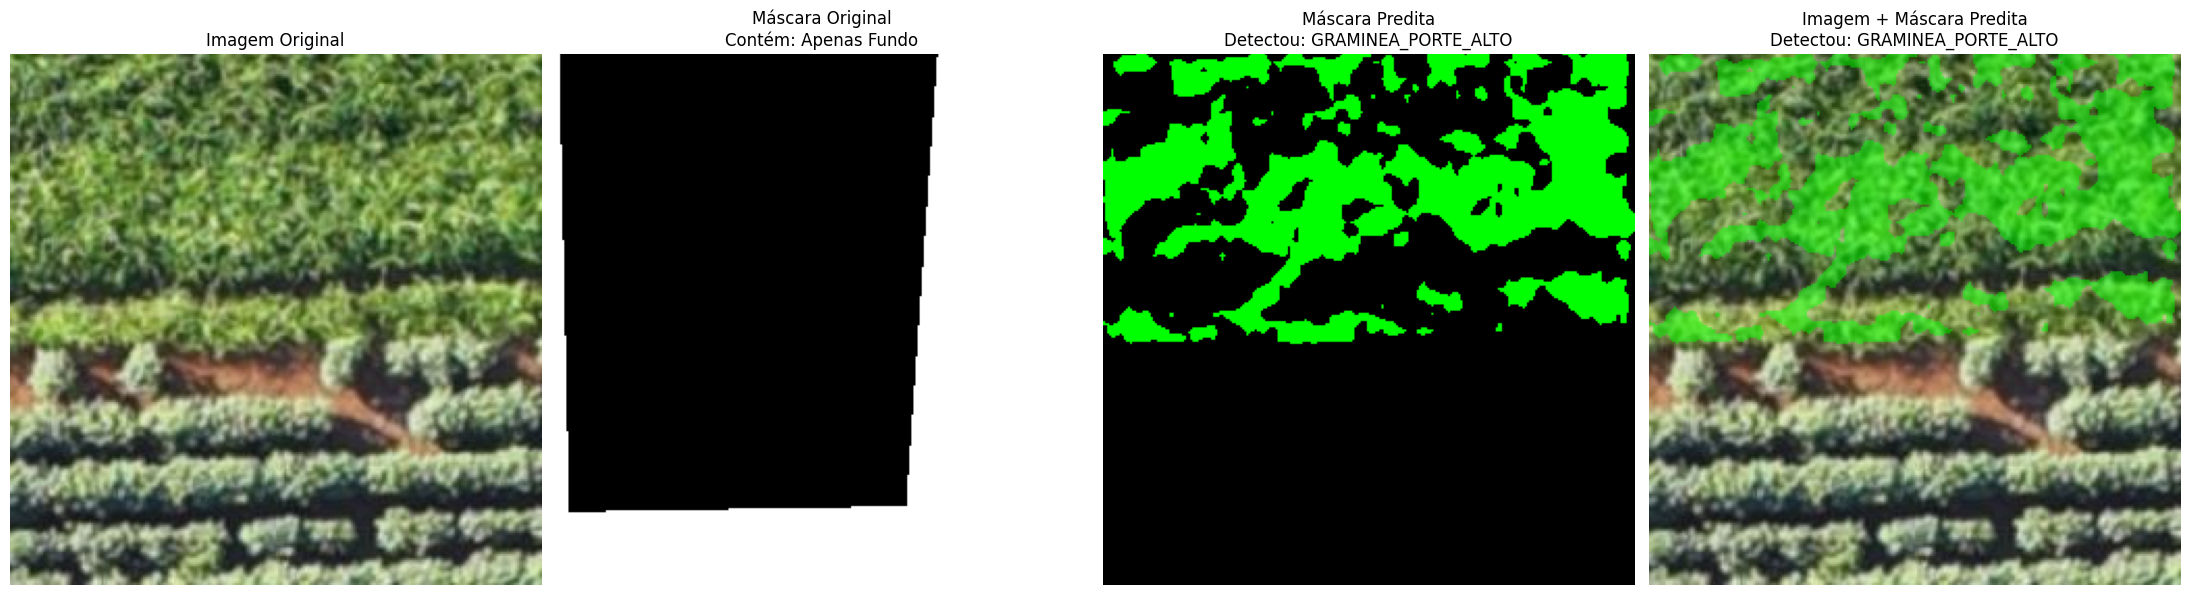

In [141]:

# 2. Visualizar algumas imagens
visualize_prediction(best_model, test_dataset)

In [150]:
# Testar agora o melhor modelo com Data Augmentation

train_dataset_aug = DaninhasDataset(train_files, transform=get_aug_transform())
train_loader_aug = DataLoader(train_dataset_aug, batch_size=16, shuffle=True)

model_deeplab_com_aug = smp.DeepLabV3Plus(encoder_name=ENCODER, encoder_weights='imagenet', classes=CLASSES)

history_aug = train_experiment(
    model=model_deeplab_com_aug,
    name="DeepLabV3+_Augmented",
    train_loader=train_loader_aug,
    val_loader=val_loader,
    epochs=15
)


Iniciando treinamento do modelo: DeepLabV3+_Augmented


Ep 1: Train IoU: 0.1652 | Val IoU: 0.2145


Ep 2: Train IoU: 0.2183 | Val IoU: 0.2254


Ep 3: Train IoU: 0.2446 | Val IoU: 0.2627


Ep 4: Train IoU: 0.2591 | Val IoU: 0.3542


Ep 5: Train IoU: 0.3093 | Val IoU: 0.3012


Ep 6: Train IoU: 0.3088 | Val IoU: 0.3351


Ep 7: Train IoU: 0.3431 | Val IoU: 0.3452


Ep 8: Train IoU: 0.3556 | Val IoU: 0.3080


Ep 9: Train IoU: 0.3522 | Val IoU: 0.3796


Ep 10: Train IoU: 0.3653 | Val IoU: 0.4082


Ep 11: Train IoU: 0.3775 | Val IoU: 0.2322


Ep 12: Train IoU: 0.3657 | Val IoU: 0.3629


Ep 13: Train IoU: 0.3933 | Val IoU: 0.3797


Ep 14: Train IoU: 0.4049 | Val IoU: 0.3890


Ep 15: Train IoU: 0.4110 | Val IoU: 0.3053
Fim do treino de DeepLabV3+_Augmented. Melhor IoU: 0.4082
